In [1]:
import torch as th
import numpy as np

In [2]:
hidden_activations = th.load("./activations/hidde_activations_2023_30_06_16_49.pt")
output_activations = th.load("./activations/output_activation2023_30_06_16_49.pt")
predicted = th.load("./predicted/predicted_labels2023_30_06_16_49.pt")

hidden_activations = hidden_activations.numpy()
output_activations = output_activations.numpy()
predicted = predicted.numpy()

In [3]:
hidden_layer_neurons = hidden_activations.shape[1]

## Compute mapper

It performs mapper algorithm and return:

- a html file inside mapper_outputs folder to see the resulting graph
- indexes_from_cluster_output, data_from_cluster_output variables, which stores respectively:
  - the indexes of the test point in each cluster
  - the activations (so a vector of 10 or 100 elements, depending if outputor hidden) of the test point in each cluster


In [4]:
from src.compute_mapper import compute_mapper
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

indexes_from_cluster_output, data_from_cluster_output = compute_mapper(
    data=output_activations, title="output activations", n_cubes=10, cube=9
)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: max
	Distance matrices: None
	Scalers: StandardScaler()
..Projecting on data shaped (10000, 10)

..Projecting data using: max

..Scaling with: StandardScaler()

Mapping on data shaped (10000, 10) using lens shaped (10000, 1)

Creating 10 hypercubes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '


Created 180 edges and 90 nodes in 0:00:12.654587.
Wrote visualization to: mapper_outputs/2023-06-30 17:01:43.386090.html


Verify the correspondenece in the clusters in the output layer: take the output activations of the test points and with the clusters obtained by applying mapper algorithm, within each cluster take the ground truth labels and check if there are dominant labels within each cluster.


In [5]:
associations = (
    []
)  # associations[i] is a tuple with the label associated with i-th cluster, with the given probability
for i in range(10):
    labels, freq = np.unique(
        predicted[indexes_from_cluster_output[i]], return_counts=True
    )
    print(
        f"CLUSTER {i}. Labels:{labels}. Frequency: {freq} ---> Cluster {i} associated with label {labels[np.argmax(freq)]} with prob. {100*np.max(freq)/np.sum(freq)}%"
    )
    associations.append((labels[np.argmax(freq)], np.max(freq) / np.sum(freq)))

CLUSTER 0. Labels:[1 2 3 7 8 9]. Frequency: [1108   45   13   41   17    2] ---> Cluster 0 associated with label 1 with prob. 90.37520391517128%
CLUSTER 1. Labels:[0 2 3 5 7 9]. Frequency: [712   3   1   1   1   1] ---> Cluster 1 associated with label 0 with prob. 99.02642559109874%
CLUSTER 2. Labels:[0 2 3 5 8]. Frequency: [  1   6   6   1 630] ---> Cluster 2 associated with label 8 with prob. 97.82608695652173%
CLUSTER 3. Labels:[0 1 2 3 4 5 7 9]. Frequency: [  1   1   4   1 785   6  42 839] ---> Cluster 3 associated with label 9 with prob. 49.97022036926742%
CLUSTER 4. Labels:[0 1 2 3 4 5 6 7 8 9]. Frequency: [237   9 162 177  97 239 153  44 214  55] ---> Cluster 4 associated with label 5 with prob. 17.231434751261716%
CLUSTER 5. Labels:[5 7]. Frequency: [553   1] ---> Cluster 5 associated with label 5 with prob. 99.81949458483754%
CLUSTER 6. Labels:[2 3 7]. Frequency: [720   3   1] ---> Cluster 6 associated with label 2 with prob. 99.4475138121547%
CLUSTER 7. Labels:[3 4 5 6 8 9]. 

### Next step

Prendo i cluster dati da mapper nell output layer.
Per ogni cluster, prendo gli indici dei test point che stanno in que cluster (indexes_from_cluster_output).

Poi, vado a vedere le hidden activations per questi testpoint che stanno dentro lo stesso cluster.


Sono localizzate... bene!
Andiamo a vedere per il cluster 0 quali sono i neuroni corrispondenti


In [6]:
# store the hidden activations for each of the 10 cluster:
hidden_activ_per_clusters = []

for i in range(10):
    # indexes_from_cluster_output[i]

    # seleziono le hidden activation dei test point corrispondenti
    hidden_activ_per_clusters.append(hidden_activations[indexes_from_cluster_output[i]])

Ora:

- per ogni cluster:
  - per ogni elemento in un cluster:
    - considero le sue hidden activations e seleziono gli indexes delle 5 attivazioni piu grandi (che corrispondono ai neuroni dell'hidden layer che si attivano di piu per i test point che poi vanno a finire in quel cluster)


In [7]:
top_activations = [[] for _ in range(10)]
for i in range(10):
    for j in range(hidden_activ_per_clusters[i].shape[0]):
        top_activations[i].append(hidden_activ_per_clusters[i][j].argsort()[-5:][::-1])

in DICT[0] c'è il seguente: \
ci sono le top 5 HIDDEN activations per ogni test point che sta dentro il cluster 0.


In [8]:
neurons_IDs = []  # gli interi qui dentro corrispondono all'ID di un neurone
frequencies = []

for i in range(10):
    values, counts = np.unique(
        np.stack(top_activations[i]).flatten(), return_counts=True
    )
    neurons_IDs.append(values)
    frequencies.append(counts)

in unique_values[0], frequencies[0] ci sono gli indici degli hidden layer che sono collegati a un qualce test point nel cluster 0, con relative frequenze.

Alla fine della fiera questo è cio che succede: \
faccio i cluster con mapper \
prendo il primo cluster (cluster 0) \
ritrovo i test point che appartengono a quel cluster \
per ogni test point, ritrovo le 5 hidden activation piu alte collegate a quel test point, e questo lo faccio per ogni test point nel cluster (cluster 0) \
alla fine conto le frequenze di questi neuroni nell'hidden layer per vedere se c'è qualche pattern: cluster 0-neuroni nell hidden layer che vengono attiavti piu di frequente.


In [9]:
best_neurons_per_cluster = []
for i in range(10):
    idxs = list(frequencies[i].argsort()[-5:][::-1])
    best_neurons_per_cluster.append(neurons_IDs[i][idxs])

best_neurons_per_cluster

[array([954, 974, 374, 896, 461]),
 array([707, 631, 730, 458, 388]),
 array([953, 212, 409, 236, 759]),
 array([759,  17, 842, 212,  46]),
 array([212, 842, 903, 409, 759]),
 array([199, 579, 842, 582, 957]),
 array([661,  72, 118, 807,  47]),
 array([212, 728, 241, 907, 759]),
 array([898, 733, 164, 782,  27]),
 array([759, 369, 991, 834,  46])]

## Resulting plot


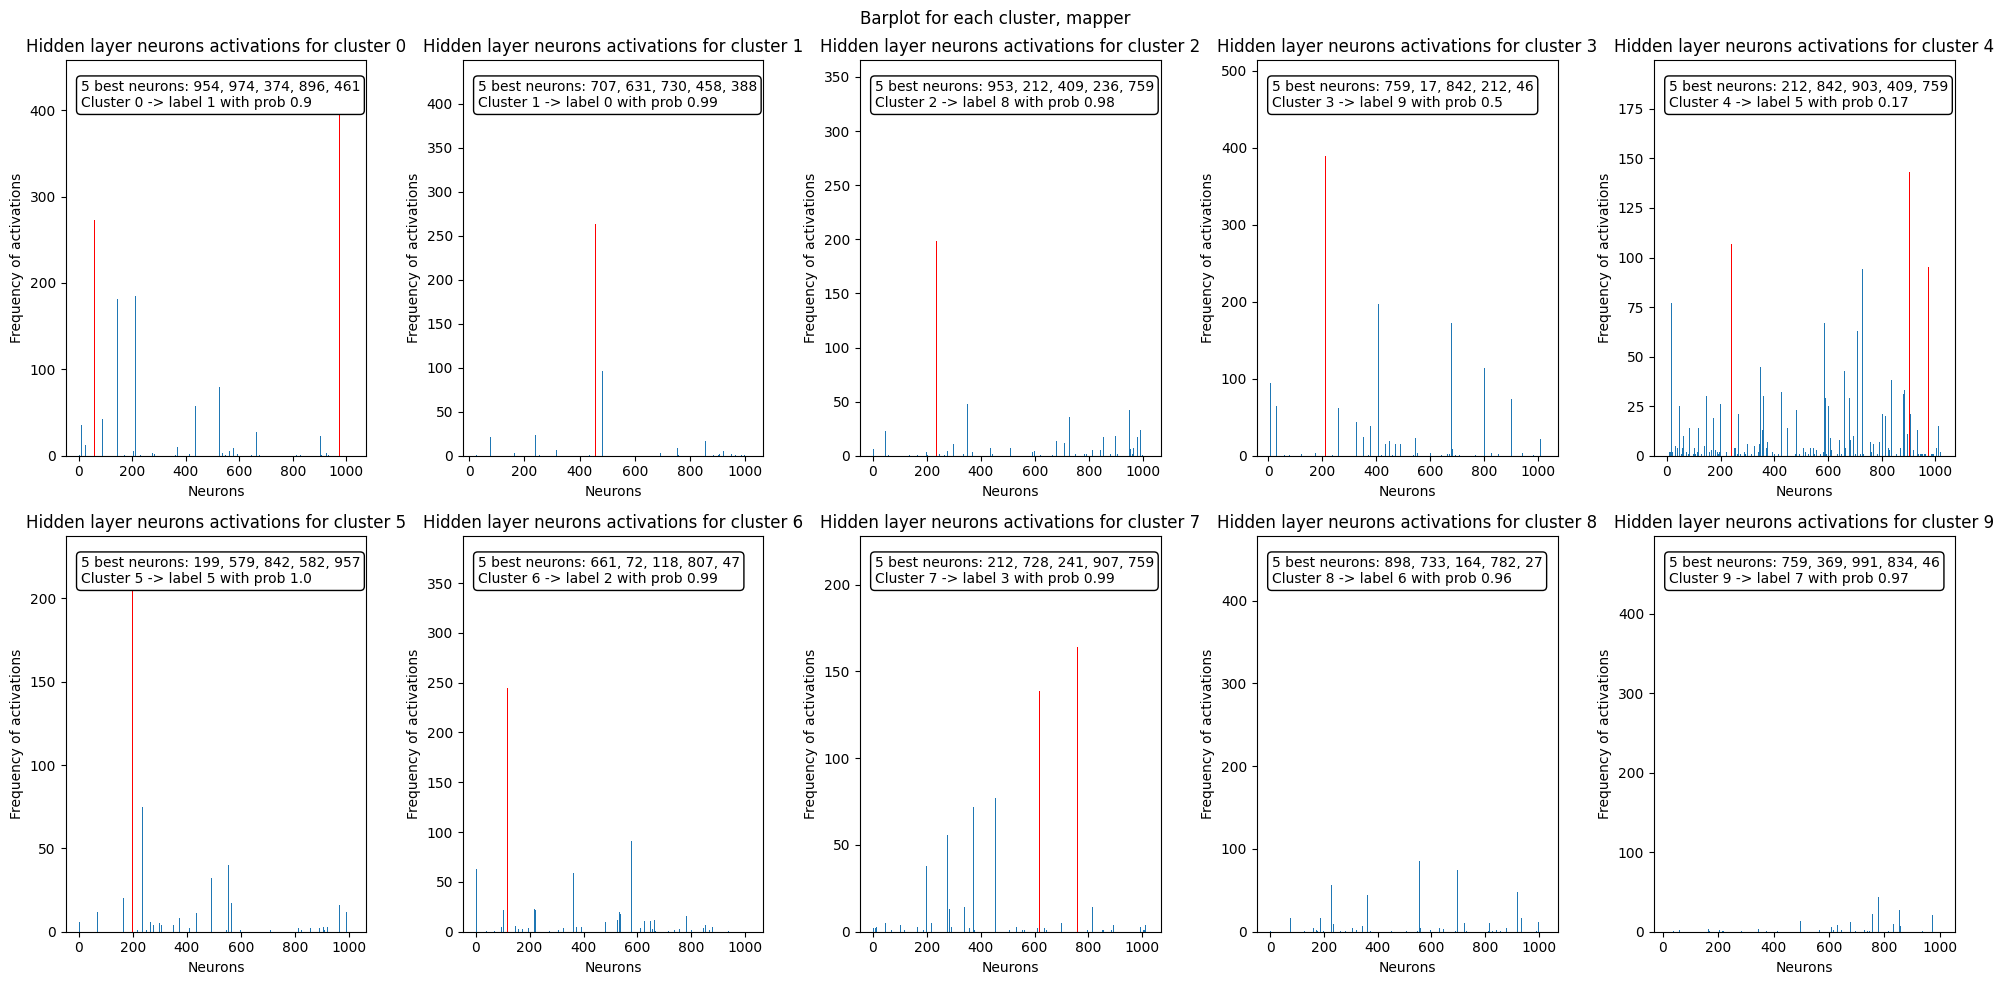

In [10]:
from src.evaluation import barplot_grid, heatmap

barplot_grid(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    suptitle="mapper",
)

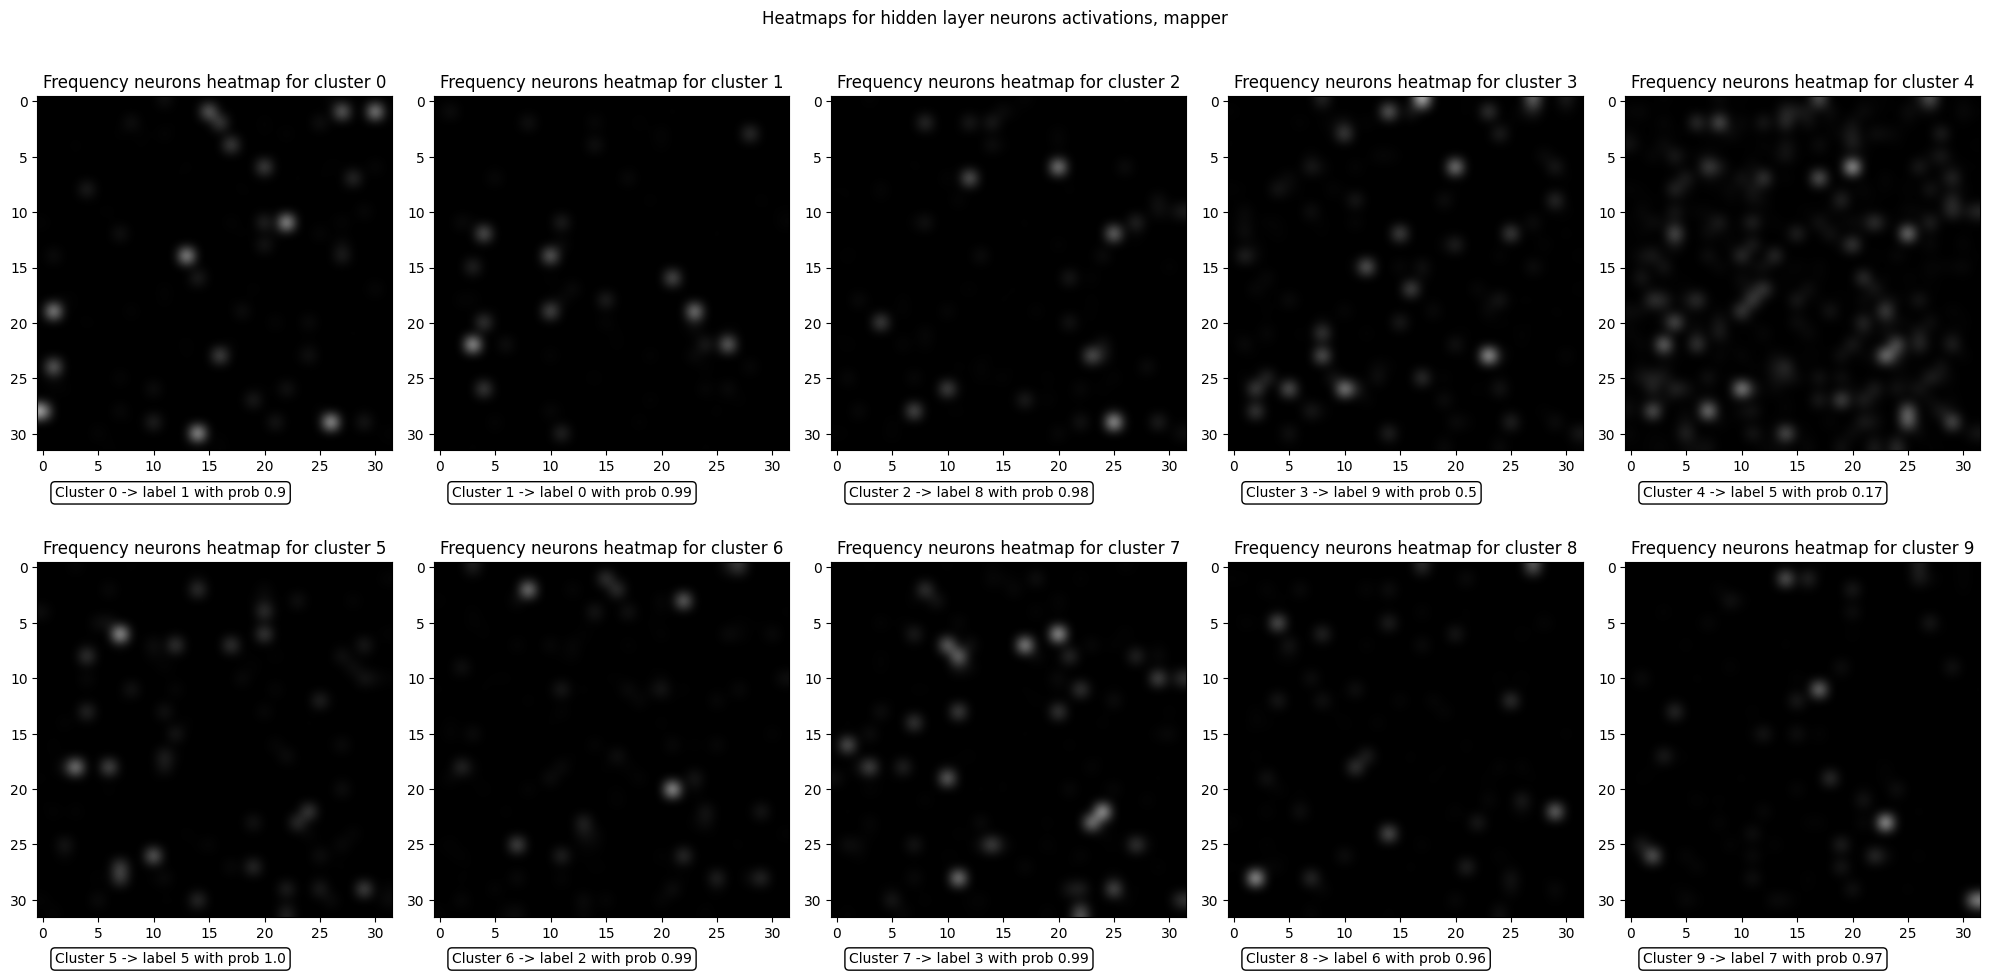

In [11]:
heatmap(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    suptitle="mapper",
)

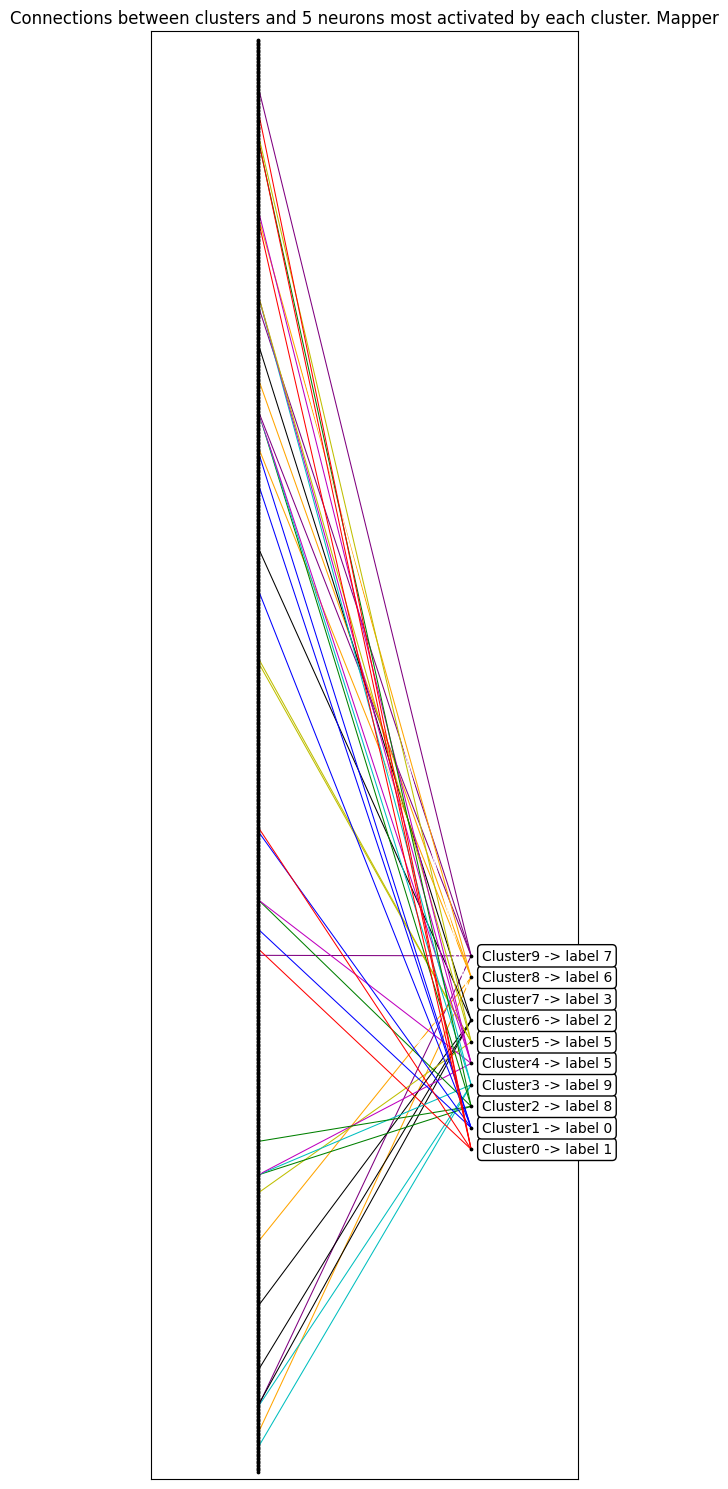

In [12]:
from src.evaluation import connections

connections(
    best_neurons_per_cluster=best_neurons_per_cluster,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    title="Mapper",
)

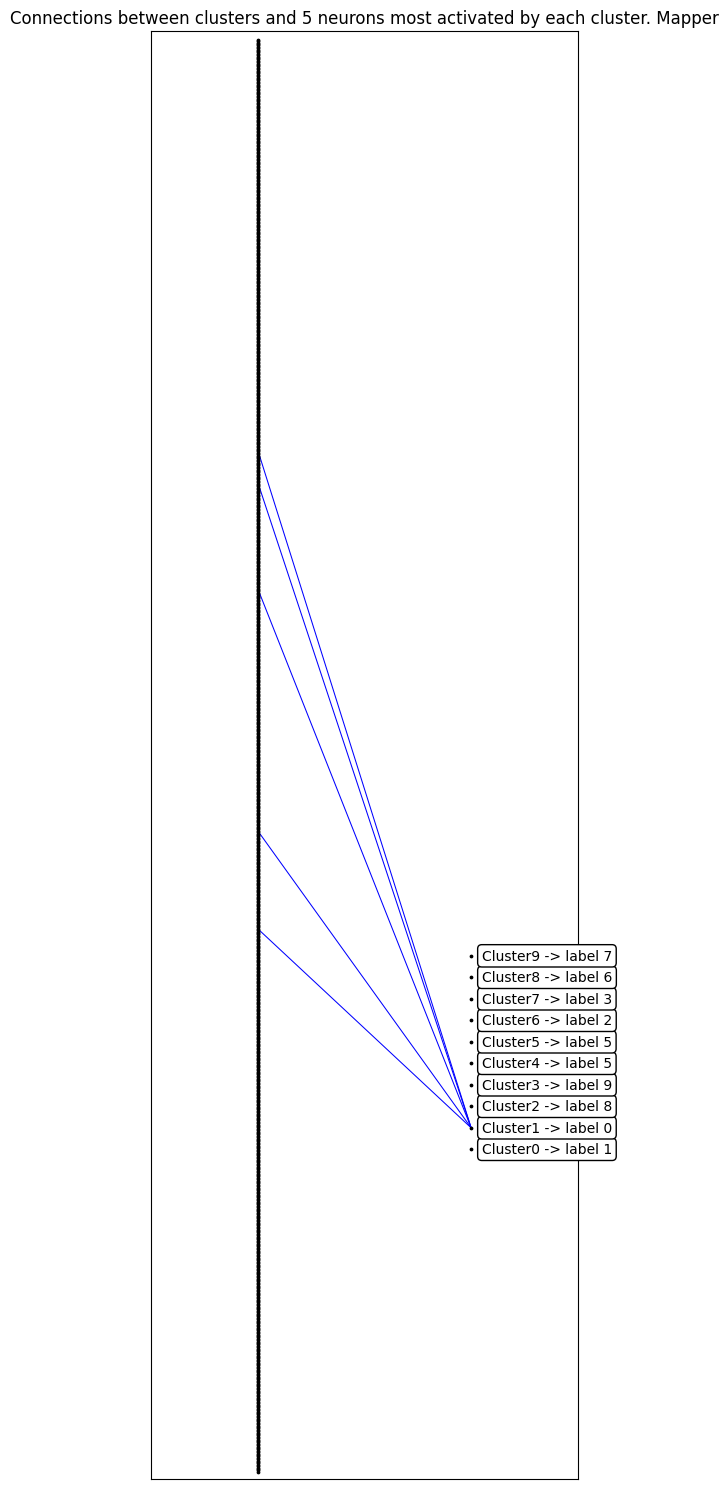

In [13]:
from src.evaluation import connections

connections(
    best_neurons_per_cluster=best_neurons_per_cluster,
    clusters=[1],
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    title="Mapper",
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

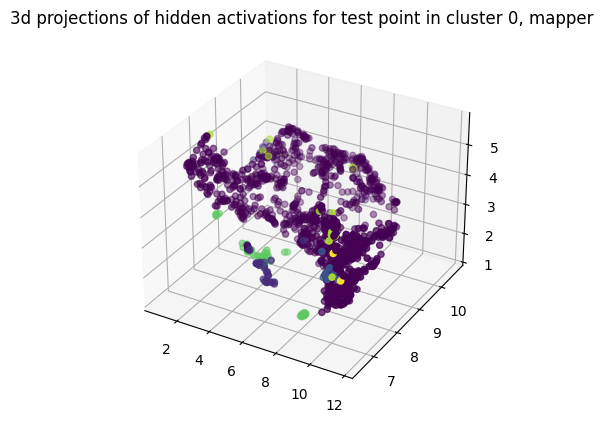

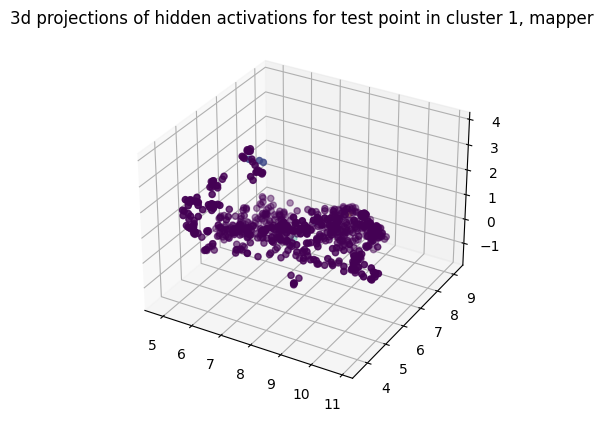

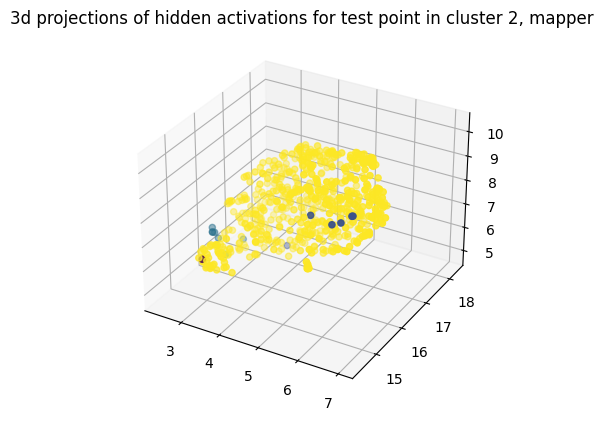

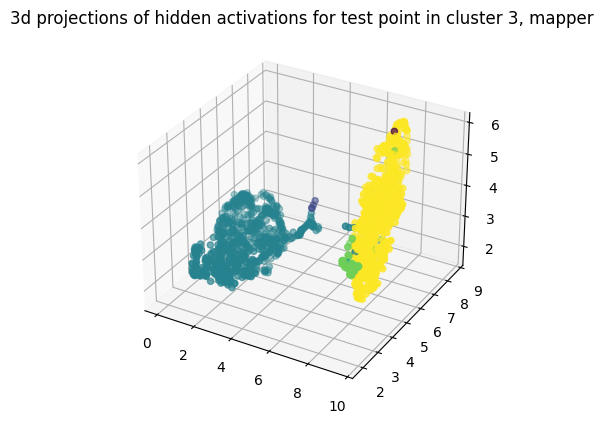

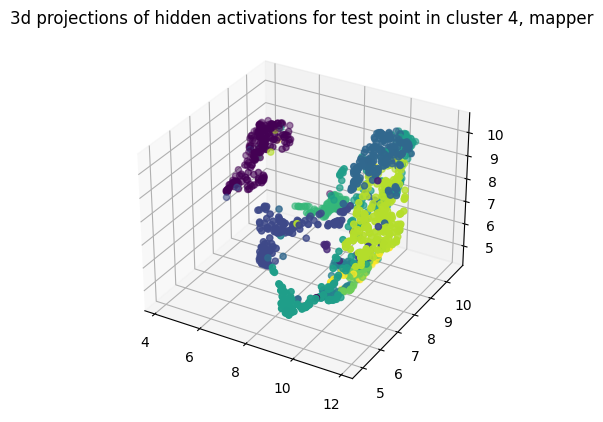

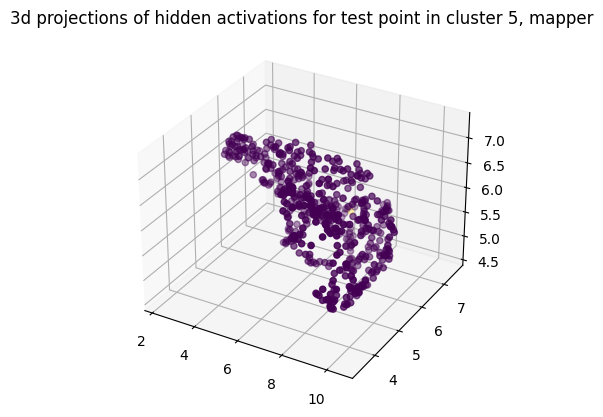

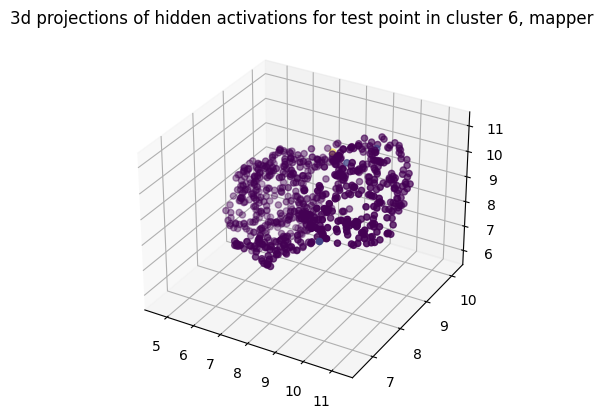

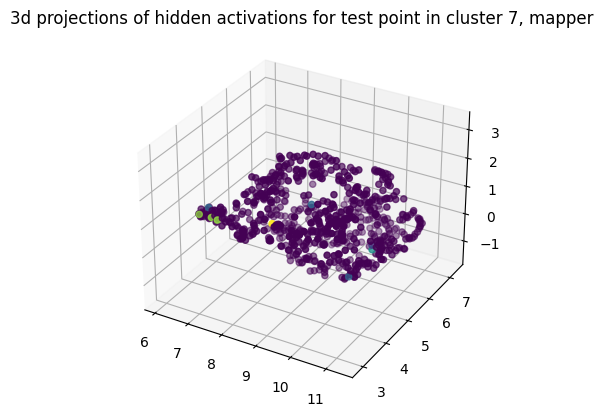

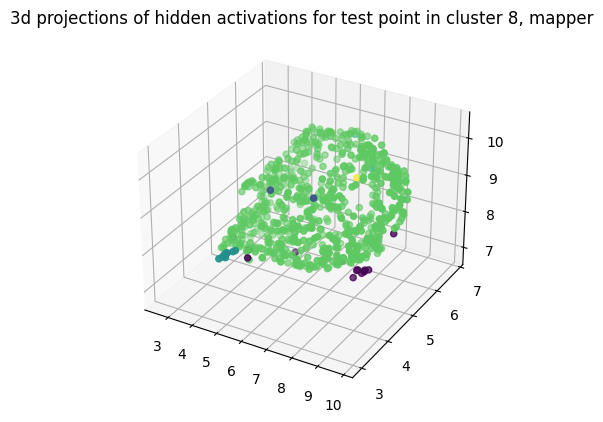

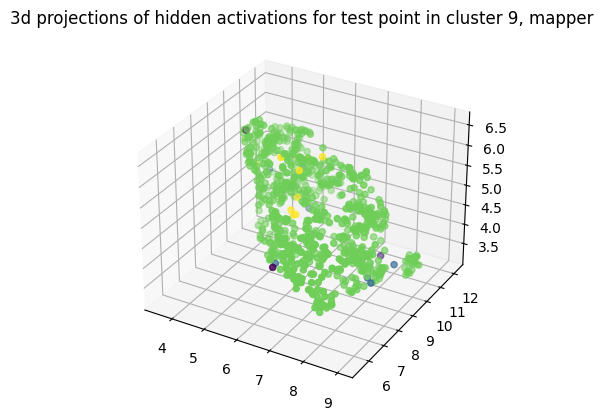

In [14]:
import matplotlib.pyplot as plt
from src.plot_manifold import plot_manifold


for i in range(10):
    plot_manifold(
        data=hidden_activations[indexes_from_cluster_output[i]],
        title=f"3d projections of hidden activations for test point in cluster {i}, mapper",
        predicted=predicted[indexes_from_cluster_output[i]],
    )
    plt.show()

## Weights analysis


In [15]:
weights_first_layer = th.load("./weights/weights_first_layer_2023_30_06_16_49.pt")

weights_first_layer = weights_first_layer.numpy()

weights_per_cluster = (
    []
)  # weights_per_cluster[i] stores the weights for the 5 'best' neurons in the i-th cluster. (nb consider the weights che uniscono il primo layer al neurone del secondo layer)
for i in range(10):
    weights_per_cluster.append(weights_first_layer[best_neurons_per_cluster[i]])

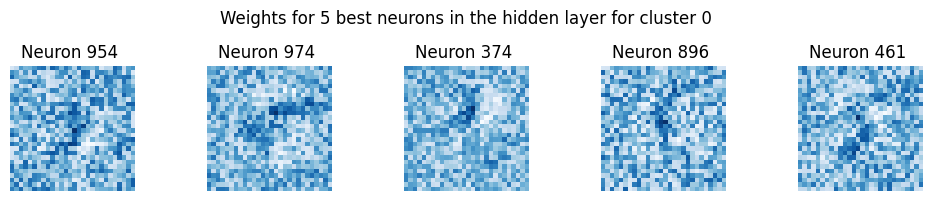

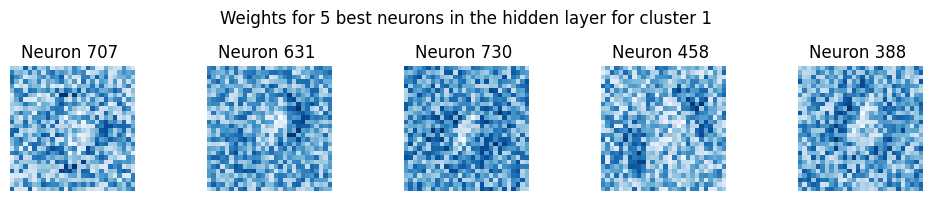

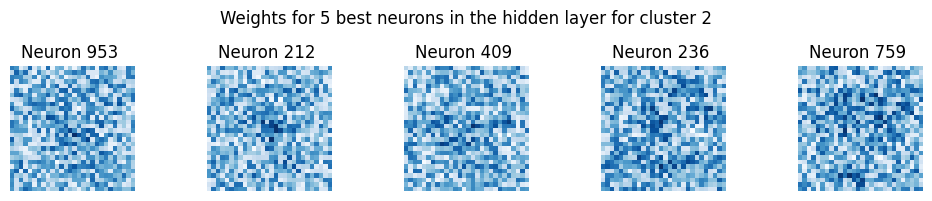

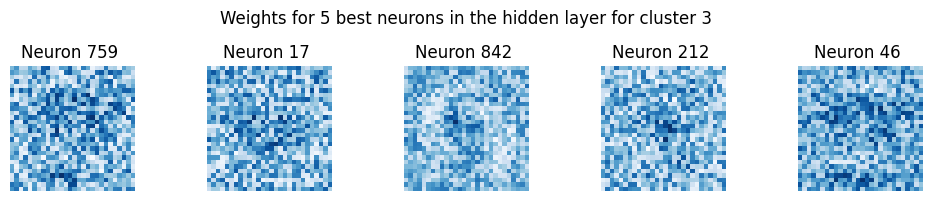

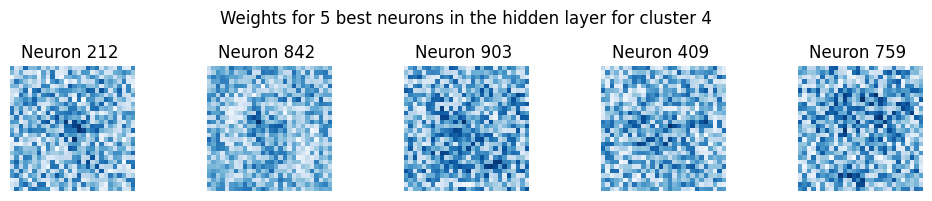

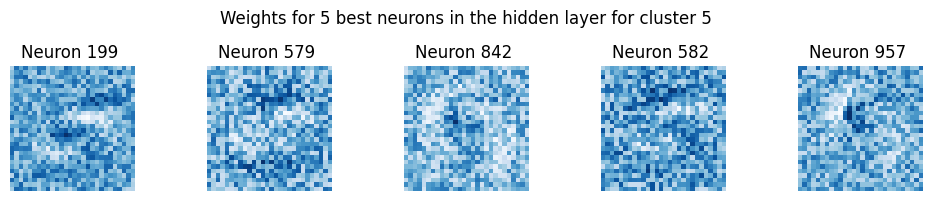

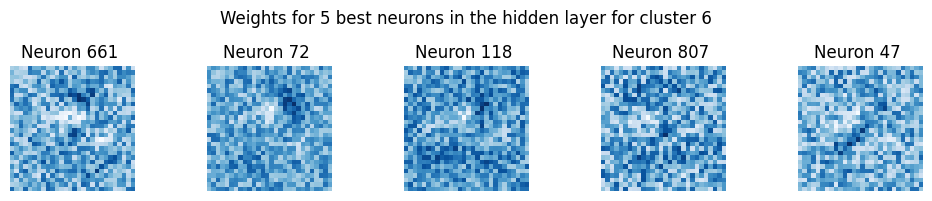

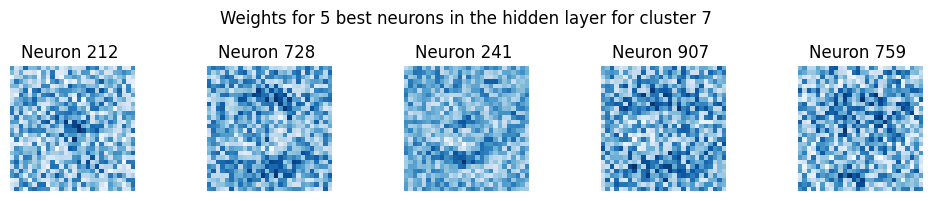

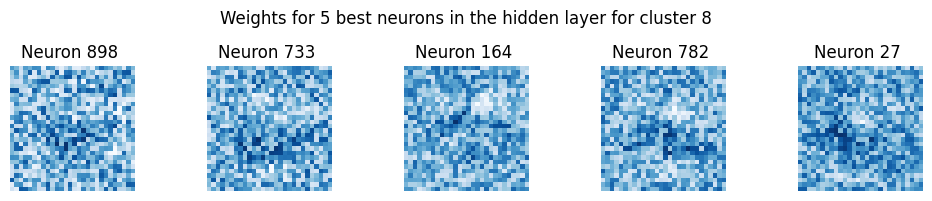

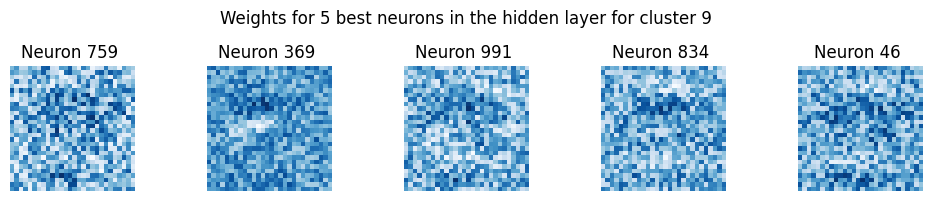

In [16]:
from matplotlib import pyplot as plt

for j in range(10):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))

    # Plot each image in the grid
    for i in range(5):
        axes[i].imshow(weights_per_cluster[j].reshape(5, 28, 28)[i], cmap="Blues")
        axes[i].axis("off")
        axes[i].set_title(f"Neuron {best_neurons_per_cluster[j][i]} ")

    # Display the grid of images
    plt.suptitle(f"Weights for 5 best neurons in the hidden layer for cluster {j}")
    plt.tight_layout()
    plt.show()